**Step 01:**
* Import **ee** and **geemap** libraries
* Authenticate and Initiatize with GEE project id
* Visualize a basemap

In [ ]:
import ee, geemap
ee.Authenticate()
ee.Initialize(project = 'jyotirmoy100')
Map = geemap.Map(basemap = 'Esri.WorldImagery')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
roi = Map.user_roi

**Step 02:**
* Import the study area boundaries from GEE asset id
* Alternatively roi can be drawn on the basemap.

In [ ]:
table = ee.FeatureCollection('asset_id')
roi = table.filter(ee.Filter.eq('Name','island_id')).geometry()

**Step 03:**
* Call landast 5 and 8 surface reflecatnce image collection
* Filter both the collection based on image path and row
* Select optical and QA_PIXEL bands
* Optionally, selected bands can be renamed
* Merge both the collection and set DateTime from the image property

In [ ]:
l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filter(ee.Filter.eq('WRS_PATH', 138))\
  .filter(ee.Filter.eq('WRS_ROW', 45)).map(lambda image: image.select(['SR_B[2-5]', 'SR_B7', 'QA_PIXEL'])\
  .rename(['green', 'red', 'nir', 'swir1', 'swir2', 'QA']))

l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filter(ee.Filter.eq('WRS_PATH', 138))\
  .filter(ee.Filter.eq('WRS_ROW', 45)).map(lambda image: image.select(['SR_B[3-7]', 'QA_PIXEL'])\
  .rename(['green', 'red', 'nir', 'swir1', 'swir2', 'QA']))

landsat = l5.merge(l8).map(
   lambda image: image.set({'DateTime': ee.Date(image.get('system:time_start')).format('yyyy-MM-dd HH:mm:ss')}))
landsat

Output hidden; open in https://colab.research.google.com to view.

**Step 04:**
* Calculate cloud percentage for the roi
*  Fiter the image collection with zero cloud cover

In [ ]:
roi_area = roi.area(maxError = 1).getInfo()
def roi_cloud(image):
  cloud_pixels = image.select('QA').bitwiseAnd(8).neq(0)
  cloud_area = cloud_pixels.reduceRegion(ee.Reducer.sum(), roi, 30).get('QA')
  return image.set('CLOUD_ROI', ee.Number(cloud_area).divide(roi_area))

cloud_free = landsat.map(roi_cloud).filter(ee.Filter.eq('CLOUD_ROI', 0)).map(
   lambda image: image.multiply(2.75e-05).add(-0.2).clip(roi)\
   .copyProperties(image, ['GEOMETRIC_RMSE_MODEL', 'DateTime']))
cloud_free

**Step 05:** Calculate water index (WI2015)

In [ ]:
def wi(image):
  index = image.expression(
      '1.7204 + (171*b(\'green\')) + (3*b(\'red\')) - (70*b(\'nir\')) - (45*b(\'swir1\')) - (71*b(\'swir2\'))')\
      .rename('wi')
  return index.copyProperties(image)
water_index = cloud_free.map(wi)
water_index

**Step 06:**
*   Calculate Otsu threshold for each image indices
*   Make binary images based on the theeshold value

In [ ]:
def otsu(image):
  histogram = image.select('wi').reduceRegion(
      reducer = ee.Reducer.histogram(), geometry = roi, scale = 10, bestEffort = True).get('wi')
  frequency_bins = ee.Array(ee.Dictionary(histogram).get('histogram'))
  mean_bins = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
  frequency = frequency_bins.reduce(ee.Reducer.sum(), [0]).get([0])
  sum = mean_bins.multiply(frequency_bins).reduce(ee.Reducer.sum(), [0]).get([0])
  mean = sum.divide(frequency)
  indices = ee.List.sequence(1, mean_bins.length().get([0]))

  def between_class_variance(t):
    left_frequency_bins = frequency_bins.slice(0, 0, t)
    left_frequency = left_frequency_bins.reduce(ee.Reducer.sum(), [0]).get([0])
    left_mean_bins = mean_bins.slice(0, 0, t)
    left_mean = left_mean_bins.multiply(left_frequency_bins).reduce(ee.Reducer.sum(), [0]).get([0])\
                .divide(left_frequency)
    right_frequency = frequency.subtract(left_frequency)
    right_mean = sum.subtract(left_frequency.multiply(left_mean)).divide(right_frequency)
    return left_frequency.multiply(left_mean.subtract(mean).pow(2))\
          .add(right_frequency.multiply(right_mean.subtract(mean).pow(2)))

  variance_list = indices.map(between_class_variance)
  threshold = mean_bins.sort(variance_list).get([-1])
  water = image.lt(threshold).rename('water')
  return water.set('Threshold', threshold).copyProperties(image)
binary = water_index.map(otsu)
binary

**Step 07:** (optional) Plot a image histogram and visualize the threshold value

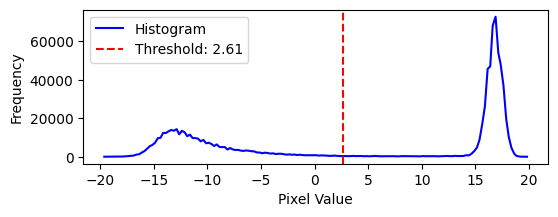

In [ ]:
import matplotlib.pyplot as plt
histogram = water_index.first().reduceRegion(
    reducer = ee.Reducer.histogram(),
    geometry = roi,
    scale = 10,
    bestEffort = True).get('wi')
frequency_bins = ee.Array(ee.Dictionary(histogram).get('histogram')).getInfo()
mean_bins = ee.Array(ee.Dictionary(histogram).get('bucketMeans')).getInfo()

threshold = binary.first().get('Threshold').getInfo()

plt.figure(figsize = (6, 2))
plt.plot(mean_bins, frequency_bins, color = 'blue', label = 'Histogram')
plt.axvline(x = threshold, color = 'red', linestyle = '--', label = f'Threshold: {threshold:.2f}')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Step 08:** Remove small patches of water from the land part and vice-versa.

In [ ]:
def remove_small_patches(image):
  image = image.int()
  land_filled = image.addBands(image).reduceConnectedComponents(ee.Reducer.median(), 'water', 100)\
                    .unmask(99).eq(99).And(image.neq(0))
  water_filled = land_filled.addBands(land_filled).reduceConnectedComponents(ee.Reducer.median(), 'water1', 200)\
                    .unmask(99).eq(99).And(land_filled.neq(1))
  return water_filled.rename('water').copyProperties(image)
land_water = binary.map(remove_small_patches)
land_water

**Step 09:** Convert the binary images into polygon vectors

In [ ]:
def vectors(image):
  vector = image.selfMask().reduceToVectors(
      reducer = ee.Reducer.countEvery(),
      geometry = roi,
      scale = 30,
      maxPixels = 1e15)
  return vector.map(lambda feature: feature.copyProperties(image))
boundary = ee.FeatureCollection(land_water.map(vectors).flatten())
boundary

**Step 10:** Remove samller errorneous polygons by selecting the largest polygon

In [ ]:
def max_coord_list(feature):
  coords = feature.geometry().coordinates()
  sizes = coords.map(lambda coords: ee.List(coords).size())
  max_size_index = sizes.indexOf(sizes.reduce(ee.Reducer.max()))
  largest_coords = coords.get(max_size_index)
  return ee.Feature(ee.Geometry.Polygon(largest_coords))\
        .copyProperties(feature, ['DateTime', 'GEOMETRIC_RMSE_MODEL', 'Threshold'])

refined_boundary = boundary.map(max_coord_list).map(max_coord_list)
refined_boundary

**Step 11:** Convert the polygon vectors into polylines (Shorelines)

In [ ]:
def polyline(feature):
  coords = feature.geometry().coordinates()
  buffer_distance = ee.Number(30).multiply(-1)
  return feature.setGeometry(ee.Geometry.MultiLineString(coords).intersection(roi.buffer(buffer_distance)))
shoreline = refined_boundary.map(polyline)
Map.addLayer(shoreline, {'color': 'red'}, 'Shorelines', False)
shoreline
Map

**Step 12:** Export the shorelines in Google Drive

In [ ]:
geemap.ee_export_vector_to_drive(
  collection = shoreline,
  folder = 'folder_name',
  fileNamePrefix = 'file_name',
  fileFormat = 'SHP')